## Team 2413:
- Maryam Gholami Shiri (2013071)
- Muhammad Usama Qasim (2040472)
- Laura Schulze (2122311)
- Savina Tsichli (10738280)

# Exercise 4: Restricted Boltzmann Machines (RBMs)
We want to study the performances of an RBM, and, by looking at its learned weights and biases,
better understand the correlations in the data (from file x_RBM_2024_exercise.dat, N=104
configurations with L=10 bits). Use an RBM with M=3 hidden units.

In [1]:
import numpy as np
from numpy import exp, sqrt, abs
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
plt.rcParams['font.size'] = 13

Load Data:

In [3]:
dname="DATA"; fname=dname+'/x_RBM_2024_exercise.dat'


# loading data: each row is a list of visible units
# NOTE: data "x" here is named "v" for "visible"
v = np.loadtxt(fname, delimiter=" ",dtype=int)
# store in v0, because later we will shuffle v
v0 = np.copy(v)
# to start, take a small subsample
# v = v[1:11]
N = len(v)
L = len(v[1])

#SPINS = True
SPINS = False

if SPINS:
    # sigmoid takes into account energy difference =2
    GAP=2
    # convert 0,1 -> -1,1
    v = 2*v - 1
    vmin=-1
else:
    GAP=1
    vmin=0

print(f'each of N={N} data has L={L} digits')

for i in range(min(12,N)):
    if SPINS: print(v0[i],"\n->",v[i])
    else: print(v[i])
print('...')

each of N=10000 data has L=10 digits
[0 0 1 1 0 0 0 0 1 1]
[0 0 0 1 0 0 0 1 0 0]
[1 0 0 0 1 0 1 0 0 0]
[0 1 1 1 0 1 0 1 0 0]
[1 1 1 0 1 1 1 1 0 0]
[0 1 0 0 1 1 1 0 0 0]
[1 0 1 0 0 0 1 1 1 1]
[1 0 1 1 0 1 1 0 0 0]
[1 0 1 0 0 0 0 1 1 1]
[1 1 0 0 1 1 0 0 0 0]
[0 1 0 1 0 0 0 0 1 1]
[1 1 0 1 1 1 1 1 0 0]
...


Functions:

In [4]:
def create_coord(np,x0,f=1.0):
    x=[x0] * np
    #print(x)
    y=list(range(np))
    if np > 1: # to avoid division by 0 for M=1
        for i in range(np):
            y[i] = f*(y[i]/(np-1.) - 0.5)
    return (x,y)

def mycolor(val):
    if val>0: return 'red'
    elif val<0: return 'blue'
    else: return 'black'

def plotgraph(epoch=0):
    fig, ax = plt.subplots(1,1 , figsize=(7, 3.3))
    ax.tick_params(left=False,bottom=False)
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.yaxis.set_major_formatter(NullFormatter())
    
    A=1./max(w.max(),-w.min())
    
    for i in range(L):
        for j in range(M):
            ex, ey, col = (y1[i],y2[j]),(x1[i],x2[j]),mycolor(w[i][j])
            ax.plot(ex, ey, col, zorder=1, alpha=A*abs(w[i][j]))
    # Scatter plot on top of lines
    #A=300./(a.max()+b.max())
    A=300.
    for i in range(L):
        ax.scatter(y1[i],x1[i], s=A*abs(a[i]), zorder=2, c=mycolor(a[i]))
    for j in range(M):
        ax.scatter(y2[j], x2[j], s=min(300,A*abs(b[j])), zorder=2, c=mycolor(b[j]), marker="s")
    ax.set_title(f'>0 red, <0 blue, epoch={epoch}')
    ax.text(-0.51,0.85,"hidden\nlayer")
    plt.show()
    
def activate(v_in,wei,bias,DE,info=False):
    act = np.dot(v_in, wei) + bias
    n = np.shape(act)
    prob = 1. / (1. + exp(-DE*act))
    v_out = np.full(n, vmin, dtype=int) # a list on -1's or 0's
    v_out[np.random.random_sample(n) < prob] = 1 # activate the 1's with probability prob
    if info:
        print('input=', v_in)
        print('act=',act)
        print('prob=',prob)
        print('output=',v_out)
    return v_out

## 4.1 
Increase the number of contrastive divergence steps from n=1 to n=5.

(10000, 10)
Training with 1 CD steps...


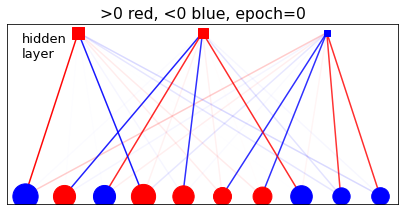

Training with 2 CD steps...


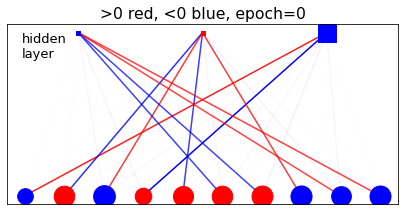

Training with 3 CD steps...


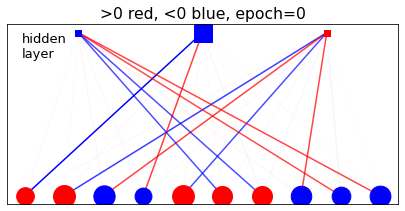

Training with 4 CD steps...


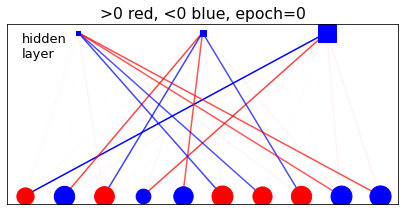

Training with 5 CD steps...


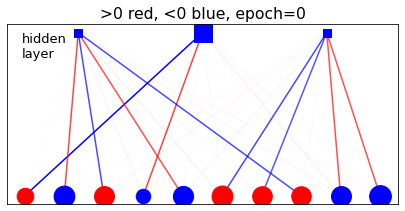

In [5]:
# Load data
data = np.loadtxt('x_RBM_2024_exercise.dat')
print(data.shape)

# Initialize RBM Parameters
L = 10  # Number of visible units
M = 3   # Number of hidden units
W = np.random.randn(L, M)  # Weight matrix
b_visible = np.zeros(L)     # Visible bias
b_hidden = np.zeros(M)      # Hidden bias

# Define the sigmoid function
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

# Contrastive Divergence (CD) training with multiple steps
def CD_train(data, W, b_visible, b_hidden, learning_rate=0.1, k=1):
    num_data = len(data)
    for _ in range(k):
        # Positive phase
        positive_hidden = sigmoid(np.dot(data, W) + b_hidden)
        positive_associations = np.dot(data.T, positive_hidden)

        # Negative phase
        negative_visible = np.random.binomial(1, sigmoid(np.dot(positive_hidden, W.T) + b_visible))
        negative_hidden = sigmoid(np.dot(negative_visible, W) + b_hidden)
        negative_associations = np.dot(negative_visible.T, negative_hidden)

        # Update parameters
        W += learning_rate * ((positive_associations - negative_associations) / num_data)
        b_visible += learning_rate * np.mean(data - negative_visible, axis=0)
        b_hidden += learning_rate * np.mean(positive_hidden - negative_hidden, axis=0)

# Training Loop for different numbers of CD steps
epochs = 100          # Number of epochs
batch_size = 32       # Batch size
num_batches = len(data) // batch_size
n_steps_range = range(1, 6)  # Range of CD steps

for n_steps in n_steps_range:
    print(f"Training with {n_steps} CD steps...")
    W = np.random.randn(L, M)  # Reinitialize weights for each set of CD steps

    w = []  # To store weights at each epoch
    for epoch in range(epochs):
        # Shuffle the data for each epoch
        np.random.shuffle(data)
        
        for batch_idx in range(num_batches):
            batch_data = data[batch_idx * batch_size: (batch_idx + 1) * batch_size]
            
            # Update RBM parameters using CD with multiple steps
            CD_train(batch_data, W, b_visible, b_hidden, k=n_steps)
        
        # Save the weights at the end of each epoch
        w.append(W.copy())

    # Plotting the weights of the RBM after training for each set of CD steps
    w = np.array(w)

    def create_coord(np, x0, f=1.0):
        x = [x0] * np
        y = list(range(np))
        for i in range(np):
            y[i] = f * (y[i] / (np - 1.) - 0.5)
        return (x, y)

    (x1, y1) = create_coord(L, 0)
    (x2, y2) = create_coord(M, 1, f=0.7)

    def mycolor(val):
        if val > 0:
            return 'red'
        elif val < 0:
            return 'blue'
        else:
            return 'black'

    def plotgraph(epoch=0):
        fig, ax = plt.subplots(1, 1, figsize=(7, 3.3))
        ax.tick_params(left=False, bottom=False)
        ax.xaxis.set_major_formatter(NullFormatter())
        ax.yaxis.set_major_formatter(NullFormatter())

        A = 1. / max(w.max(), -w.min())
        for i in range(L):
            for j in range(M):
                ex, ey, col = (y1[i], y2[j]), (x1[i], x2[j]), mycolor(w[-1, i, j])
                ax.plot(ex, ey, col, zorder=1, alpha=A * abs(w[-1, i, j]))

        A = 300.
        for i in range(L):
            ax.scatter(y1[i], x1[i], s=A * abs(b_visible[i]), zorder=2, c=mycolor(b_visible[i]))

        for j in range(M):
            ax.scatter(y2[j], x2[j], s=min(300, A * abs(b_hidden[j])), zorder=2, c=mycolor(b_hidden[j]), marker="s")

        ax.set_title(f'>0 red, <0 blue, epoch={epoch}')
        ax.text(-0.51, 0.85, "hidden\nlayer")
        plt.show()

    plotgraph()


## 4.2
Compute the log-likelihood $\mathscr{L}$ during the training, at every epoch, or every minibatch update if it reaches a maximum already in the first epoch. Use “t” as an index of this “time”, indicating the unit in the figures.

(10000, 10)
Epoch 1, Log-Likelihood: -4.04201102726343
Epoch 2, Log-Likelihood: -5.608342128718272
Epoch 3, Log-Likelihood: -4.875628295444517
Epoch 4, Log-Likelihood: -4.8784760112746
Epoch 5, Log-Likelihood: -5.5833219456003
Epoch 6, Log-Likelihood: -4.668157371440083
Epoch 7, Log-Likelihood: -4.597189899672558
Epoch 8, Log-Likelihood: -3.7209740764437345
Epoch 9, Log-Likelihood: -3.674525036249701
Epoch 10, Log-Likelihood: -4.11206177001341
Epoch 11, Log-Likelihood: -5.660456813114168
Epoch 12, Log-Likelihood: -4.884645789256592
Epoch 13, Log-Likelihood: -5.482882665770533
Epoch 14, Log-Likelihood: -6.734342097506193
Epoch 15, Log-Likelihood: -5.763803281791121
Epoch 16, Log-Likelihood: -3.131439027871276
Epoch 17, Log-Likelihood: -2.2916334380017442
Epoch 18, Log-Likelihood: -3.5933596944616855
Epoch 19, Log-Likelihood: -2.652818192006232
Epoch 20, Log-Likelihood: -2.8820498009710733
Epoch 21, Log-Likelihood: -5.7843677124107575
Epoch 22, Log-Likelihood: -3.426368110501672
Epoch 23

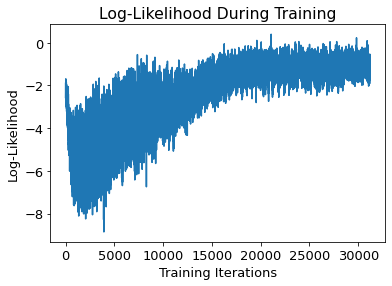

In [6]:
import numpy as np

# Load data
data = np.loadtxt('x_RBM_2024_exercise.dat')
print(data.shape)

# Initialize RBM Parameters
N_visible = 10  # Number of visible units
N_hidden = 3    # Number of hidden units
W = np.random.randn(N_visible, N_hidden)  # Weight matrix
b_visible = np.zeros(N_visible)           # Visible bias
b_hidden = np.zeros(N_hidden)             # Hidden bias

# Define the log-likelihood function
def log_likelihood(data, W, b_visible, b_hidden):
    energy = np.sum(-np.dot(data, b_visible)[:, np.newaxis] - np.log(1 + np.exp(np.dot(data, W) + b_hidden)), axis=1)
    return np.mean(energy)

# Define the sigmoid function
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

# Contrastive Divergence (CD) training
def CD_train(data, W, b_visible, b_hidden, learning_rate=0.1, k=1):
    num_data = len(data)
    # Positive phase
    positive_hidden = sigmoid(np.dot(data, W) + b_hidden)
    positive_associations = np.dot(data.T, positive_hidden)

    # Negative phase
    negative_visible = np.random.binomial(1, sigmoid(np.dot(positive_hidden, W.T) + b_visible))
    for i in range(k):
        negative_hidden = sigmoid(np.dot(negative_visible, W) + b_hidden)
        negative_visible = np.random.binomial(1, sigmoid(np.dot(negative_hidden, W.T) + b_visible))
    negative_associations = np.dot(negative_visible.T, negative_hidden)

    # Update parameters
    W += learning_rate * ((positive_associations - negative_associations) / num_data)
    b_visible += learning_rate * np.mean(data - negative_visible, axis=0)
    b_hidden += learning_rate * np.mean(positive_hidden - negative_hidden, axis=0)

# Training Loop
epochs = 100  # Number of epochs
batch_size = 32  # Batch size
num_batches = len(data) // batch_size

log_likelihoods = []

for epoch in range(epochs):
    # Shuffle the data for each epoch
    np.random.shuffle(data)
    
    for batch_idx in range(num_batches):
        batch_data = data[batch_idx * batch_size: (batch_idx + 1) * batch_size]
        
        # Update RBM parameters using CD
        CD_train(batch_data, W, b_visible, b_hidden)
        
        # Compute log-likelihood after each minibatch update
        ll = log_likelihood(batch_data, W, b_visible, b_hidden)
        log_likelihoods.append(ll)
    print(f"Epoch {epoch+1}, Log-Likelihood: {ll}")

# Plot log-likelihood over time
import matplotlib.pyplot as plt

plt.plot(log_likelihoods)
plt.xlabel('Training Iterations')
plt.ylabel('Log-Likelihood')
plt.title('Log-Likelihood During Training')
plt.show()

## 4.3
Try RBMs with different numbers of hidden units: M=1, 2, 3 (done above), 4, 5, and 6.

some helper functions:

In [7]:
# let's write functions for plotting & to initialize and train the RBM
def create_plot(w, epoch=0):
    # get correct shape from weights
    L, M = w.shape
    # define coordinate grid
    (x1,y1)=create_coord(L,0)
    (x2,y2)=create_coord(M,1,f=0.7)

    # plot graph
    # just like the plotgraph function
    # but this time with the correct L and M
    fig, ax = plt.subplots(1,1 , figsize=(7, 3.3))
    ax.tick_params(left=False,bottom=False)
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.yaxis.set_major_formatter(NullFormatter())
    
    A=1./max(w.max(),-w.min())
    
    for i in range(L):
        for j in range(M):
            ex, ey, col = (y1[i],y2[j]),(x1[i],x2[j]),mycolor(w[i][j])
            ax.plot(ex, ey, col, zorder=1, alpha=A*abs(w[i][j]))
    # Scatter plot on top of lines
    #A=300./(a.max()+b.max())
    A=300.
    for i in range(L):
        ax.scatter(y1[i],x1[i], s=A*abs(a[i]), zorder=2, c=mycolor(a[i]))
    for j in range(M):
        ax.scatter(y2[j], x2[j], s=min(300,A*abs(b[j])), zorder=2, c=mycolor(b[j]), marker="s")
    ax.set_title(f'>0 red, <0 blue, epoch={epoch}')
    ax.text(-0.51,0.85,"hidden\nlayer")
    plt.show()
    
def init_RBM(L, M=3):
    # range of each initial weight
    sigma = sqrt(4. / float(L + M))
    # random seed for reproducibility
    np.random.seed(12345)
    # initial weights from a Normal distr. (see literature, e.g. page 98 of Mehta's review)
    w = sigma * np.random.randn(L,M)
    a = sigma * np.random.randn(L)
    b = np.zeros(M)
    print("w=",w);print("a=",a);print("b=",b)
    return w, a, b

def train_RBM(w, a, b, l_rate = 1.0, showIntermediatePlots=True):
    L, M = w.shape
    print(L, M)
    #create_plot(w, epoch=0)    
    
    # minibatch
    mini, m = 500, 0
    
    # train model
    print('===================================================')
    for epoch in range(100):
        # aggregate normalization of batch statistics and learning rate in l_rate_m
        l_rate_m = l_rate / mini
        for k in range(N):
            if m==0:
                # initialize averages in miniblock
                v_data, v_model = np.zeros(L),np.zeros(L)
                h_data, h_model = np.zeros(M),np.zeros(M)
                vh_data,vh_model= np.zeros((L,M)),np.zeros((L,M))
    
            # positive CD phase: generating h 
            h = activate(v[k],w,b,GAP)
            # negative CD phase: generating fantasy vf
            vf = activate(h,w.T,a,GAP)
            # one more positive CD phase: generating fantasy h from fantasy vf 
            hf = activate(vf,w,b,GAP)
    
            v_data  += v[k]
            v_model += vf
            h_data  += h
            h_model += hf
            vh_data += np.outer(v[k].T,h)
            vh_model+= np.outer(vf.T,hf)
        
            m += 1
            # minibatch
            if m==mini:
                # gradient of the likelihood: follow it along its positive direction
                # with a "vanilla" SGD
                dw = l_rate_m*(vh_data - vh_model)
                da = l_rate_m*(v_data - v_model)
                db = l_rate_m*(h_data - h_model)
                if epoch<=1 and k<=mini:
                    print('----------- epoch =',epoch,'  k=',k,'  m=',m)
                    print('dw =',dw)
                    print('da =',da)
                    print('db =',db)
                # basic step of vanilla gradient descent, from eq.(211)
                w = w + dw
                a = a + da
                b = b + db
                m=0
        
        # randomize the order of input data
        np.random.shuffle(v)
        # decrease the learning rate (here as a power law)
        l_rate = l_rate / (0.01 * l_rate + 1)
        
        if showIntermediatePlots:
            if epoch%10==9:
                create_plot(w, epoch+1)
                print('l_rate = ',l_rate)
        else: # show only last plot
            if epoch+1==100:
                create_plot(w, epoch+1)
                print('l_rate = ',l_rate)
            

w= [[-0.11355138]
 [ 0.26566996]
 [-0.28813276]
 [-0.30826371]
 [ 1.09041887]
 [ 0.77292249]
 [ 0.05153602]
 [ 0.15628465]
 [ 0.42657697]
 [ 0.69139759]
 [ 0.55868813]
 [-0.7190141 ]]
a= [ 0.15253791  0.12697802  0.75046323  0.49170253 -1.11030861 -0.20626113
  0.92580867 -0.24327472 -0.29939469  0.26458368  1.80218983 -0.56647511]
b= [0.]
12 1
----------- epoch = 0   k= 499   m= 500
dw = [[-0.038]
 [-0.082]
 [-0.17 ]
 [-0.104]
 [ 0.01 ]
 [-0.082]
 [-0.26 ]
 [-0.01 ]
 [-0.002]
 [-0.212]
 [-0.366]
 [ 0.112]]
da = [ 0.002 -0.054 -0.124 -0.048  0.032 -0.05  -0.25   0.034  0.042 -0.216
 -0.398  0.198]
db = [-0.096]
----------- epoch = 1   k= 499   m= 500
dw = [[ 0.08712871]
 [ 0.02574257]
 [ 0.03366337]
 [ 0.03168317]
 [-0.00792079]
 [ 0.02178218]
 [ 0.03762376]
 [ 0.0019802 ]
 [ 0.07128713]
 [ 0.02376238]
 [ 0.01782178]
 [-0.03366337]]
da = [ 0.05346535  0.01386139  0.01782178  0.01386139 -0.07326733 -0.02970297
  0.06138614  0.03168317  0.03366337  0.01584158 -0.00594059 -0.07524752]
db 

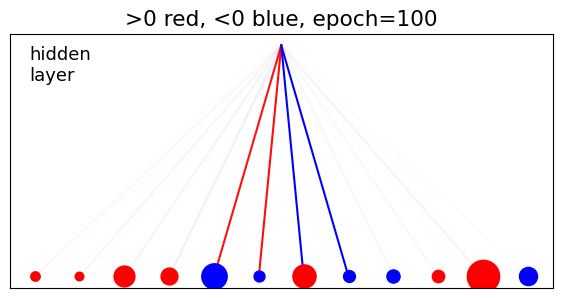

l_rate =  0.5000000000000009
w= [[-0.10942085  0.25600598]
 [-0.27765167 -0.29705034]
 [ 1.05075391  0.74480675]
 [ 0.04966135  0.15059965]
 [ 0.41105985  0.66624739]
 [ 0.53836536 -0.69285933]
 [ 0.14698921  0.12235908]
 [ 0.72316447  0.47381641]
 [-1.06992015 -0.1987582 ]
 [ 0.89213155 -0.23442538]
 [-0.28850394  0.25495921]
 [ 1.73663357 -0.54586907]]
a= [-3.08466139e-01  6.63456126e-02  1.61753753e-01  2.79967947e-01
  5.02599612e-04  7.18296549e-01 -3.81405303e-01 -4.44270254e-01
 -1.26694211e+00 -9.94618479e-01 -4.60094183e-01  2.99410253e-01]
b= [0. 0.]
12 2
----------- epoch = 0   k= 499   m= 500
dw = [[-0.018  0.012]
 [ 0.008  0.064]
 [-0.334 -0.158]
 [-0.128 -0.046]
 [-0.2   -0.084]
 [-0.228 -0.114]
 [ 0.012  0.06 ]
 [-0.16  -0.074]
 [ 0.314  0.246]
 [ 0.028  0.034]
 [ 0.042  0.036]
 [-0.3   -0.192]]
da = [ 0.06   0.086 -0.296 -0.082 -0.152 -0.174  0.068 -0.118  0.43   0.094
  0.098 -0.29 ]
db = [-0.12  -0.002]
----------- epoch = 1   k= 499   m= 500
dw = [[-0.01782178 -0.059

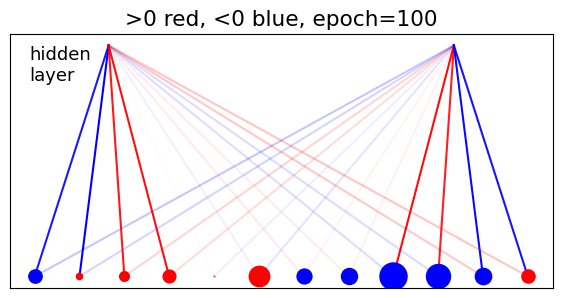

l_rate =  0.5000000000000009
w= [[-1.05710581e-01  2.47325276e-01 -2.68236999e-01]
 [-2.86977895e-01  1.01512472e+00  7.19551678e-01]
 [ 4.79774212e-02  1.45493088e-01  3.97121546e-01]
 [ 6.43656130e-01  5.20110348e-01 -6.69365702e-01]
 [ 1.42005069e-01  1.18210102e-01  6.98643250e-01]
 [ 4.57750143e-01 -1.03364106e+00 -1.92018661e-01]
 [ 8.61880964e-01 -2.26476438e-01 -2.78721284e-01]
 [ 2.46314000e-01  1.67774743e+00 -5.27359626e-01]
 [-2.98006602e-01  6.40959511e-02  1.56268971e-01]
 [ 2.70474733e-01  4.85557355e-04  6.93940393e-01]
 [-3.68472529e-01 -4.29205842e-01 -1.22398236e+00]
 [-9.60892739e-01 -4.44493209e-01  2.89257786e-01]]
a= [-0.65372576  0.06187846 -0.54919547  0.1718999  -1.21839863 -0.10304354
 -0.79628307 -0.50128587 -0.67494752  0.14787037  0.19519016 -0.38930533]
b= [0. 0. 0.]
12 3
----------- epoch = 0   k= 499   m= 500
dw = [[ 0.06   0.078  0.082]
 [-0.138 -0.154 -0.134]
 [ 0.042 -0.034 -0.022]
 [-0.05  -0.15  -0.072]
 [ 0.044  0.022  0.04 ]
 [ 0.054  0.032  0.06

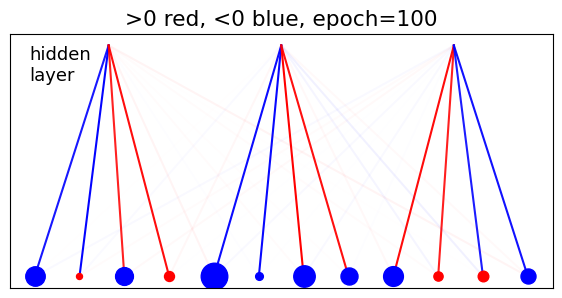

l_rate =  0.5000000000000009
w= [[-1.02353830e-01  2.39471669e-01 -2.59719358e-01 -2.77865152e-01]
 [ 9.82890286e-01  6.96702916e-01  4.64539384e-02  1.40873076e-01]
 [ 3.84511284e-01  6.23217368e-01  5.03594679e-01 -6.48110555e-01]
 [ 1.37495817e-01  1.14456439e-01  6.76458418e-01  4.43214670e-01]
 [-1.00081865e+00 -1.85921269e-01  8.34512655e-01 -2.19284868e-01]
 [-2.69870723e-01  2.38492505e-01  1.62447196e+00 -5.10613762e-01]
 [-2.88543652e-01  6.20606378e-02  1.51306781e-01  2.61886034e-01]
 [ 4.70138888e-04  6.71904897e-01 -3.56771993e-01 -4.15576769e-01]
 [-1.18511583e+00 -9.30380394e-01 -4.30378699e-01  2.80072647e-01]
 [-6.32967246e-01  5.99135623e-02 -5.31756224e-01  1.66441358e-01]
 [-1.17970940e+00 -9.97714777e-02 -7.70997764e-01 -4.85367956e-01]
 [-6.53515125e-01  1.43174874e-01  1.88992055e-01 -3.76943267e-01]]
a= [ 0.16564283  0.67487111  0.03493834  0.12333705 -0.0059308   0.5024058
  0.66359731 -0.45963078 -0.77455322  0.0110923   0.37918157 -0.33026216]
b= [0. 0. 0. 0

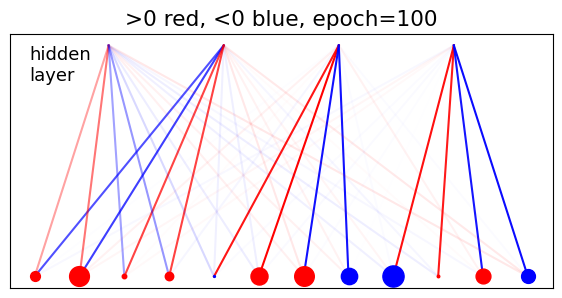

l_rate =  0.5000000000000009
w= [[-9.92978003e-02  2.32321644e-01 -2.51964787e-01 -2.69568793e-01
   9.53543640e-01]
 [ 6.75901109e-01  4.50669399e-02  1.36666959e-01  3.73030738e-01
   6.04609656e-01]
 [ 4.88558601e-01 -6.28759594e-01  1.33390535e-01  1.11039056e-01
   6.56261060e-01]
 [ 4.29981388e-01 -9.70936712e-01 -1.80370124e-01  8.09596193e-01
  -2.12737570e-01]
 [-2.61813058e-01  2.31371715e-01  1.57596929e+00 -4.95368112e-01
  -2.79928459e-01]
 [ 6.02076624e-02  1.46789139e-01  2.54066772e-01  4.56101716e-04
   6.51843496e-01]
 [-3.46119673e-01 -4.03168686e-01 -1.14973123e+00 -9.02601562e-01
  -4.17528667e-01]
 [ 2.71710378e-01 -6.14068426e-01  5.81246932e-02 -5.15879313e-01
   1.61471835e-01]
 [-1.14448623e+00 -9.67925508e-02 -7.47977698e-01 -4.70876082e-01
  -6.34002798e-01]
 [ 1.38900030e-01  1.83349225e-01 -3.65688684e-01  1.60697144e-01
   6.54721143e-01]
 [ 3.38951728e-02  1.19654519e-01 -5.75372166e-03  4.87405214e-01
   6.43783950e-01]
 [-4.45907353e-01 -7.51426997e-01

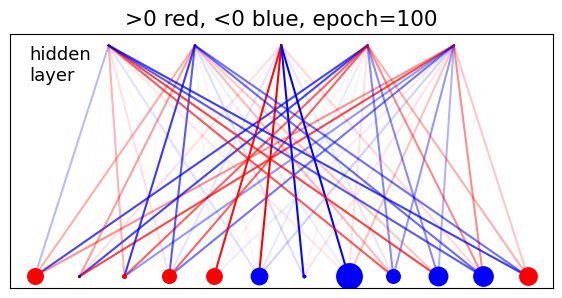

l_rate =  0.5000000000000009
w= [[-9.65001161e-02  2.25776055e-01 -2.44865759e-01 -2.61973778e-01
   9.26677849e-01  6.56857809e-01]
 [ 4.37971931e-02  1.32816410e-01  3.62520715e-01  5.87574970e-01
   4.74793616e-01 -6.11044491e-01]
 [ 1.29632299e-01  1.07910566e-01  6.37771112e-01  4.17866799e-01
  -9.43580877e-01 -1.75288253e-01]
 [ 7.86786076e-01 -2.06743756e-01 -2.54436557e-01  2.24852890e-01
   1.53156685e+00 -4.81411272e-01]
 [-2.72041564e-01  5.85113305e-02  1.42653401e-01  2.46908521e-01
   4.43251194e-04  6.33478012e-01]
 [-3.36367860e-01 -3.91809536e-01 -1.11733792e+00 -8.77171048e-01
  -4.05764929e-01  2.64055023e-01]
 [-5.96767242e-01  5.64870483e-02 -5.01344576e-01  1.56922417e-01
  -1.11224069e+00 -9.40654512e-02]
 [-7.26903663e-01 -4.57609298e-01 -6.16139969e-01  1.34986565e-01
   1.78183419e-01 -3.55385521e-01]
 [ 1.56169553e-01  6.36274582e-01  3.29401870e-02  1.16283291e-01
  -5.59161237e-03  4.73672726e-01]
 [ 6.25645541e-01 -4.33344054e-01 -7.30255778e-01  1.045792

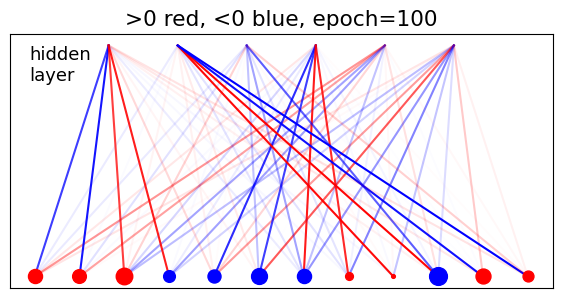

l_rate =  0.5000000000000009


In [9]:
mvals = np.arange(1,7)
# M=1 needs a different coordinate creation
# bc we get a division by 0 otherwise
for m in mvals:    
    # initialise RBM
    w, a, b = init_RBM(L, M=m)
    # train RBM, show only last plot (at epoch==100)
    train_RBM(w, a, b, showIntermediatePlots=False)  

## 4.4
for M=3, plot $\mathscr{L}$ as a function of “t”, comparing the two contrastive divergence cases (n=1 and n=5). Then, for n=1, plot $\mathscr{L}$ as a function of “t”, comparing the two cases with different M.

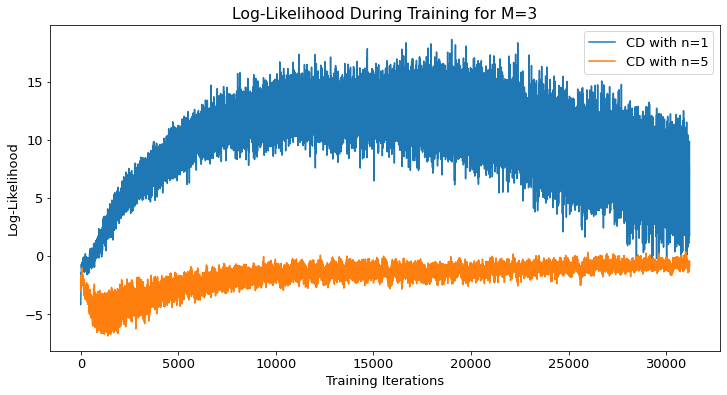

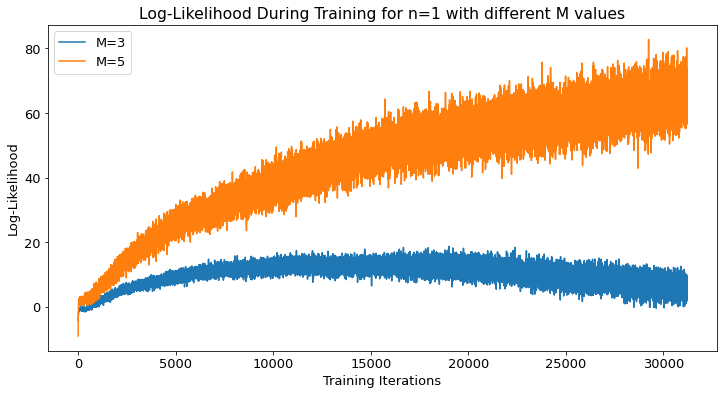

In [15]:
def simulate_rbm(N_visible, N_hidden, num_CD_steps, epochs, batch_size, data):
    W = np.random.randn(N_visible, N_hidden)
    b_visible = np.zeros(N_visible)
    b_hidden = np.zeros(N_hidden)

    def sigmoid(x):
        return 1 / (1 + np.exp(-x))
    
    def log_likelihood(data, W, b_visible, b_hidden):
        energy = np.sum(-np.dot(data, b_visible)[:, np.newaxis] - np.log(1 + np.exp(np.dot(data, W) + b_hidden)), axis=1)
        return np.mean(energy)

    def CD_train(data, W, b_visible, b_hidden, learning_rate=0.1, k=1):
        num_data = len(data)
        positive_hidden = sigmoid(np.dot(data, W) + b_hidden)
        positive_associations = np.dot(data.T, positive_hidden)
        negative_visible = np.random.binomial(1, sigmoid(np.dot(positive_hidden, W.T) + b_visible))
        for i in range(k):
            negative_hidden = sigmoid(np.dot(negative_visible, W) + b_hidden)
            negative_visible = np.random.binomial(1, sigmoid(np.dot(negative_hidden, W.T) + b_visible))
        negative_associations = np.dot(negative_visible.T, negative_hidden)
        W += learning_rate * ((positive_associations - negative_associations) / num_data)
        b_visible += learning_rate * np.mean(data - negative_visible, axis=0)
        b_hidden += learning_rate * np.mean(positive_hidden - negative_hidden, axis=0)

    log_likelihoods = []

    for epoch in range(epochs):
        np.random.shuffle(data)
        for batch_idx in range(len(data) // batch_size):
            batch_data = data[batch_idx * batch_size: (batch_idx + 1) * batch_size]
            CD_train(batch_data, W, b_visible, b_hidden, k=num_CD_steps)
            ll = log_likelihood(batch_data, W, b_visible, b_hidden)
            log_likelihoods.append(ll)
    
    return log_likelihoods


# Simulate for n=1 and n=5 with M=3
log_likelihoods_n1 = simulate_rbm(N_visible=10, N_hidden=3, num_CD_steps=1, epochs=100, batch_size=32, data=data)
log_likelihoods_n5 = simulate_rbm(N_visible=10, N_hidden=3, num_CD_steps=5, epochs=100, batch_size=32, data=data)

# Plot log-likelihood as a function of training iterations for n=1 and n=5
plt.figure(figsize=(12, 6))
plt.plot(log_likelihoods_n1, label='CD with n=1')
plt.plot(log_likelihoods_n5, label='CD with n=5')
plt.xlabel('Training Iterations')
plt.ylabel('Log-Likelihood')
plt.title('Log-Likelihood During Training for M=3')
plt.legend()
plt.show()

# Simulate for different values of M with n=1
log_likelihoods_M3 = log_likelihoods_n1  # Already simulated for M=3, n=1
log_likelihoods_M5 = simulate_rbm(N_visible=10, N_hidden=5, num_CD_steps=1, epochs=100, batch_size=32, data=data)

# Plot log-likelihood as a function of training iterations for M=3 and M=5 with n=1
plt.figure(figsize=(12, 6))
plt.plot(log_likelihoods_M3, label='M=3')
plt.plot(log_likelihoods_M5, label='M=5')
plt.xlabel('Training Iterations')
plt.ylabel('Log-Likelihood')
plt.title('Log-Likelihood During Training for n=1 with different M values')
plt.legend()
plt.show()

## 4.5
From the weights learned by the RBM, guess the structure of the data.

To compute $\mathscr{L}$ , consider full configurations x=(v,h) and their energy E(x). With $\mathscr{L}$ visible units and M hidden units, we have 2L+M possible configurations. The partition function Z is the sum of all their Boltzmann weights e-E(x). The average expectation of the energy according to data is computed by averaging the energy of each data sample vn completed with all 2M possible hidden states. Thus, in total there are N*2M configurations to use in the <E>data average.

The package `itertools` is useful for generating the possible configurations.
https://docs.python.org/3/library/itertools.html
```python
Q=4
import itertools as it
conf = it.product((0,1), repeat=Q)
all_conf=list(conf)
for x in all_conf:
print(x)
```